In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import keras
import shutil
import numpy as np
import tensorflow as tf
import seaborn as sns

In [ ]:
sns.set_style('darkgrid')

In [ ]:
FOLDER = '/content/drive/MyDrive/hackaton/Development'
#FOLDER = '/content/drive/MyDrive/MachineLearning/ClosedAI/Development'

In [ ]:
dataset_path = f"{FOLDER}/Dataset/dataset_skoltech.zip"

images_path = "/content/train/images"
masks_path = "/content/train/masks"

In [ ]:
!unzip -q {dataset_path}

In [ ]:
def change_file_type(folder_path, old_extension, new_extension):
    files = os.listdir(folder_path)

    for file in files:
        if file.endswith(old_extension):
            old_path = os.path.join(folder_path, file)
            new_file = os.path.splitext(file)[0] + new_extension
            new_path = os.path.join(folder_path, new_file)

            shutil.move(old_path, new_path)

In [ ]:
change_file_type(images_path, ".png", ".jpg")
change_file_type(masks_path, ".png", ".jpg")

In [ ]:
image = Image.open('/content/train/images/train_image_000.jpg')
mask = Image.open('/content/train/masks/train_mask_000.jpg')

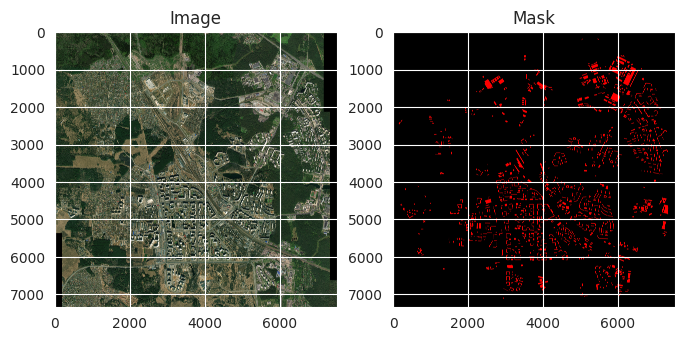

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(image)
axs[0].set_title('Image')
axs[1].imshow(mask)
axs[1].set_title('Mask')
plt.show()

In [ ]:
prepared_dataset_path = 'Prepared_dataset'

In [ ]:
IMG_SIZE = 256, 256
NUM_CLASSES = 2

In [ ]:
def color2index(color):
    intensity = np.sum(color[:3])
    return 1 if intensity > 20 else 0

def index2color(index):
    return [0, 0, 0] if index == 0 else [255, 0, 0]

def rgb_to_ohe(y, num_classes):
    y = np.array(y)
    indices = np.apply_along_axis(color2index, -1, y)
    yt = tf.keras.utils.to_categorical(indices, num_classes=num_classes)
    return yt

In [ ]:
def count_pixels(image, target_color):
    img = np.array(image)
    count = np.sum(np.all(img == target_color, axis=-1))
    return count

In [ ]:
q = 0

def save(index, x_path, y_path, pixel_treshold=500):
    global q

    x_img = Image.open(x_path).convert('RGB')
    y_img = Image.open(y_path).convert('RGB')

    x_pieces = split_image(x_img, IMG_SIZE)
    y_pieces = split_image(y_img, IMG_SIZE)

    for i, (x_piece, y_piece) in enumerate(zip(x_pieces, y_pieces)):

        white_count = count_pixels(x_piece, np.array([255, 255, 255]))
        black_count = count_pixels(x_piece, np.array([0, 0, 0]))

        if white_count > pixel_treshold or black_count > pixel_treshold:
            continue

        #print()
        #print('White pixels:', white_count)
        #print('Black pixels:', black_count)
        #print()

        #fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        #axs[0].imshow(x_piece)
        #axs[0].set_title('Image')
        #axs[1].imshow(y_piece)
        #axs[1].set_title('Mask')
       # plt.show()


        x_piece = keras.utils.img_to_array(x_piece)
        y_piece = keras.utils.img_to_array(y_piece)
        y_piece = rgb_to_ohe(y_piece, NUM_CLASSES)

        q += 1

        np.save(f'{prepared_dataset_path}/x/{index}_{i}.npy', x_piece)
        np.save(f'{prepared_dataset_path}/y/{index}_{i}.npy', y_piece)

    return q

def split_image(image, piece_size):
    width, height = image.size
    pieces = []

    step = 256

    for i in range(0, width - piece_size[0], step):
        for j in range(0, height - piece_size[1], step):
            piece = image.crop((i, j, i + piece_size[0], j + piece_size[1]))
            pieces.append(piece)

    return pieces

In [ ]:
x_path_list = [f'{images_path}/{i}' for i in sorted(os.listdir(images_path)) if i[0] != '.']
y_path_list = [f'{masks_path}/{i}' for i in sorted(os.listdir(masks_path)) if i[0] != '.']
print('x:', len(x_path_list), ' ', 'y:', len(y_path_list))

x: 21   y: 21


In [ ]:
!rm -rf {prepared_dataset_path}
!mkdir {prepared_dataset_path}
!mkdir {prepared_dataset_path + '/x'}
!mkdir {prepared_dataset_path + '/y'}

In [ ]:
i = 0

for x_path, y_path in zip(x_path_list, y_path_list):
    m = save(i, x_path, y_path)
    print(i, '=>', len(x_path_list), m)
    i += 1

0 => 21 779
1 => 21 1100
2 => 21 1611
3 => 21 2250
4 => 21 3368
5 => 21 4809


KeyboardInterrupt: ignored

In [ ]:
print('x:', len(os.listdir("/content/Prepared_dataset/x")), ' ', 'y:', len(os.listdir("/content/Prepared_dataset/y")))

x: 4816   y: 4816


In [ ]:
!zip -q -r prepared_dataset_4816.zip Prepared_dataset

In [ ]:
!mv prepared_dataset_4816.zip {FOLDER + '/Dataset'}